In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def compute_image_derivative(image):
    
    '''
    Function to compute image derivative along x and y axis
    
    Input:
        image - H x W - input image
    Returns:
        list of image derivatives along x and y axis 
    '''
    
    image_x_filter = np.array([[ -1, 0, 1]])

    image_y_filter = np.array([[ -1],
                               [  0],
                               [  1]])

    image_x_derivative = cv2.filter2D(image, -1, image_x_filter)
    image_y_derivative = cv2.filter2D(image, -1, image_y_filter)
    
    return [image_x_derivative, image_y_derivative]
    
def compute_optical_flow(image_1, image_2, filter_size):
    
    '''
    Computes optical flow between two images
    
    Input:
        image_1 - H x W - input image 1
        image_2 - H x W - input image 2
        filter_size - tuple - filter size
        
    Returns:
        flow_matrix - H x W x 2 - matrix with flow vectors
        
    '''
    
    if (len(image_1.shape) > 1) and (len(image_2.shape) > 1):
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    
    image_1 = normalize_image(image_1)
    image_2 = normalize_image(image_2)
    
    image_1_derivative = compute_image_derivative(image_1)
    image_2_derivative = compute_image_derivative(image_2)
    
    # dx^2
    image_x_derivative_square = image_1_derivative[0] * image_1_derivative[0]
    
    # dy^2
    image_y_derivative_square = image_1_derivative[1] * image_1_derivative[1]
    
    # dx*dy
    image_xy_derivative = image_1_derivative[0] * image_1_derivative[1]
    
    # dt 
    image_t_derivative = image_2 - image_1
    
    image_xt_derivative = image_1_derivative[0] * image_t_derivative
    image_yt_derivative = image_1_derivative[1] * image_t_derivative
    
    summation_filter = np.ones(filter_size) 
    
    
    # computing summation dx^2, dy^2, dx*dt, dy*dt, dx*dy
    image_xt_derivative_summation = cv2.filter2D(image_xt_derivative, -1, summation_filter)
    image_yt_derivative_summation = cv2.filter2D(image_yt_derivative, -1, summation_filter)
    image_x_derivative_square_summation = cv2.filter2D(image_x_derivative_square, -1, summation_filter)
    image_y_derivative_square_summation = cv2.filter2D(image_y_derivative_square, -1, summation_filter)
    image_xy_derivative_summation = cv2.filter2D(image_xy_derivative, -1, summation_filter)
    
    flow_matrix = np.zeros((image_1.shape[0], image_1.shape[1], 2))
    
    for i in range(image_1.shape[0]):
        
        for j in range(image_1.shape[1]):
            
            # computing matrix
            optical_flow_mat = np.array([[image_x_derivative_square_summation[i, j], image_xy_derivative_summation[i, j]], 
                                        [image_xy_derivative_summation[i, j], image_y_derivative_square_summation[i, j]]])
            # print(optical_flow_mat.shape)
            b = -np.array([[image_xt_derivative_summation[i, j]], [image_yt_derivative_summation[i, j]]])
            
            flow_vector = np.linalg.pinv(optical_flow_mat) @ b
            
            factor = np.sqrt(flow_vector[0]**2 + flow_vector[1]**2)
            if factor > 0.3:
                flow_matrix[i, j, :] = flow_vector.T 
                
            # print(flow_vector)
        # print(i)
    
    
    print('Optical flow computed')
    print(np.max(flow_matrix))
    return flow_matrix

def plot_flow_image(image, flow_matrix):
    '''
    Plot flow vectors on image
    
    '''
    plt.imshow(image, 'gray')
    for i in range(0, flow_matrix.shape[0], 30):
        for j in range(0, flow_matrix.shape[1], 30):
            plt.quiver(j, i, flow_matrix[i, j, 0], flow_matrix[i, j, 1], scale = 10)
            
def normalize_image(image):
    '''
    Function to normalize image
    '''
    image = (image - np.mean(image)) /255
    
    return image

def get_good_features(image_1):
    '''
    Extract good features from image
    '''
    
    if len(image_1.shape) > 1:
        image_1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    else:
        image_1_gray = image_1
        
    corners = cv2.goodFeaturesToTrack(image_1_gray, 200, 0.01, 10)
    corners = np.int0(corners)
    corners = np.reshape(corners, (-1, 2))
    
    return corners
    
def bounding_box_tracking(directory, bbox = None):
    '''
    Function to move bounding box by the optical flow obtained from the good features within the box
    '''
    
    imageArray = []
    image_array_output = []
    
    files = [images for images in os.listdir(directory)]
    files.sort()
    
    for i in range(len(files)):
        print(i)
        fileName = directory + '/'+ files[i]
        image = cv2.imread(fileName)
        imageArray.append(image)
    
    print('Draw bounding box')
    
    if bbox is None:
        r = cv2.selectROI(imageArray[0]) 
        bbox = [r[0], r[1], r[0] + r[2], r[1] + r[3]]
        bbox = bbox
    
    cv2.destroyAllWindows()
    
    running_bbox = bbox
    filter_size = ( 31, 31)
    for i in range(len(imageArray) - 1):
        
        bounding_box_shift_x = 0
        bounding_box_shift_y = 0
        # compute flow
        flow_matrix = compute_optical_flow(imageArray[i], imageArray[i + 1], filter_size)
        corners = get_good_features(imageArray[i])
        
        corners_in_box = np.logical_and(np.logical_and(corners[:, 0] > running_bbox[0], 
                                                       corners[:, 0] < running_bbox[2]), 
                                        np.logical_and(corners[:, 1] > running_bbox[1],
                                                       corners[:, 1] < running_bbox[3]))
        
        corners_in_box = corners[corners_in_box, :]
        
        if corners_in_box.shape[0] > 0:
            
            total_points = corners_in_box.shape[0]
            
            for points in corners_in_box:
                bounding_box_shift_x += flow_matrix[points[1], points[0], 0] / total_points
                bounding_box_shift_y += flow_matrix[points[1], points[0], 1] / total_points
        
        print(running_bbox)
        running_bbox = [int(running_bbox[0] + bounding_box_shift_x), 
                        int(running_bbox[1] + bounding_box_shift_y),
                        int(running_bbox[2] + bounding_box_shift_x),
                        int(running_bbox[3] + bounding_box_shift_y)]
        
        print(running_bbox)
        
        next_image = imageArray[i + 1]
        cv2.rectangle(next_image, (int(running_bbox[0]), int(running_bbox[1])),
          (int(running_bbox[2]), int(running_bbox[3])), (0, 255, 0), 2)
        plt.imshow(next_image)
        plt.show()
        image_array_output.append(next_image)
        
    pass
    

Optical flow computed
1.8176778334267094


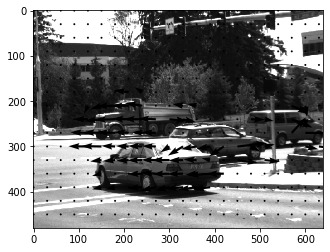

In [3]:
if __name__ == '__main__':
    
    dataset = './eval-data-gray'
    
    directory = '/Dumptruck'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    
    

Optical flow computed
5.765109935609735


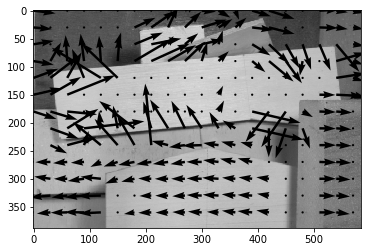

In [4]:
    directory = '/Wooden'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)
    

Optical flow computed
1.3436528180770413


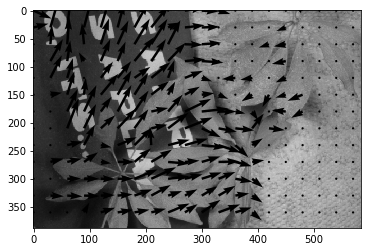

In [5]:
    directory = '/Schefflera'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
0.8440589903756118


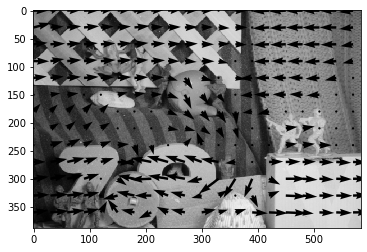

In [6]:
    directory = '/Army'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
1.5299213790854143


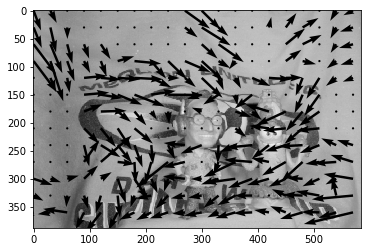

In [7]:
    directory = '/Mequon'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
2.2360458885028005


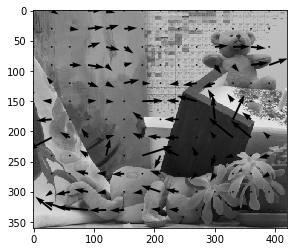

In [8]:
    directory = '/Teddy'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

Optical flow computed
2.6626510680615745


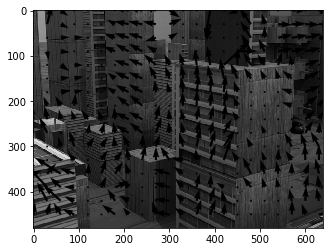

In [9]:
    directory = '/Urban'
    image_1_path = dataset + directory + '/frame10.png'
    image_2_path = dataset + directory + '/frame11.png'
    
    image_1 = cv2.imread(image_1_path)
    image_2 = cv2.imread(image_2_path)
    filter_size = ( 41, 41)
    flow_matrix = compute_optical_flow(image_1 , image_2 , filter_size)
    plot_flow_image(image_1, flow_matrix)

0
1
2
3
4
5
6
7
Draw bounding box
Optical flow computed
2.8738112414310057
[130, 284, 432, 408]
[129, 283, 431, 407]


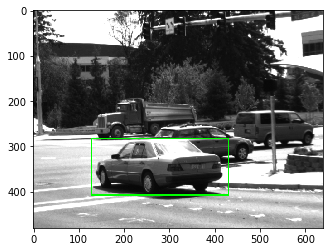

Optical flow computed
2.2956330355709134
[129, 283, 431, 407]
[128, 282, 430, 406]


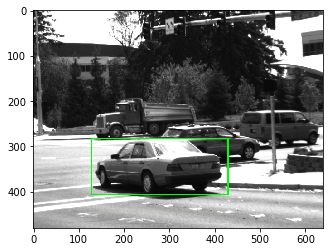

Optical flow computed
2.033606060317765
[128, 282, 430, 406]
[127, 281, 429, 405]


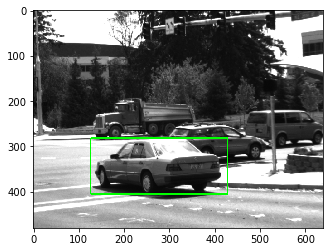

Optical flow computed
2.3447939963660724
[127, 281, 429, 405]
[126, 280, 428, 404]


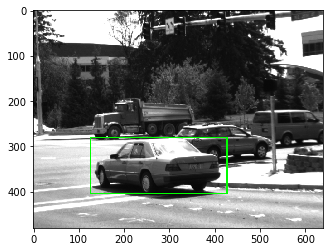

Optical flow computed
2.043988245607022
[126, 280, 428, 404]
[125, 279, 427, 403]


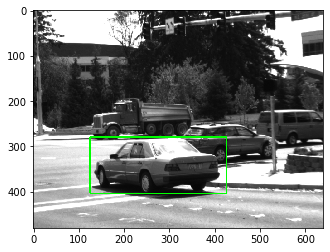

Optical flow computed
4.313141886070124
[125, 279, 427, 403]
[124, 278, 426, 402]


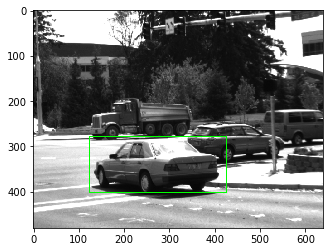

Optical flow computed
2.646981243423369
[124, 278, 426, 402]
[123, 277, 425, 401]


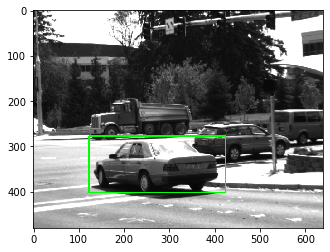

In [10]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Dumptruck'
    bbox = [119, 275, 460, 414]
    bounding_box_tracking(dataset_complete + directory)

0
1
2
3
4
5
6
7
Draw bounding box
Optical flow computed
7.041625519088246
[208, 284, 338, 461]
[207, 284, 337, 461]


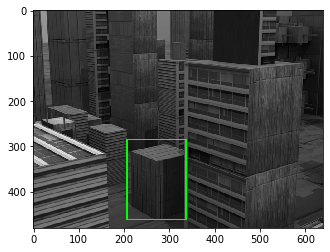

Optical flow computed
5.18297905839455
[207, 284, 337, 461]
[207, 283, 337, 460]


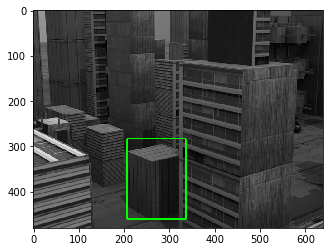

Optical flow computed
5.609497796425945
[207, 283, 337, 460]
[207, 283, 337, 460]


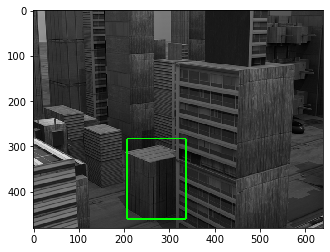

Optical flow computed
3.6354092574742185
[207, 283, 337, 460]
[206, 283, 336, 460]


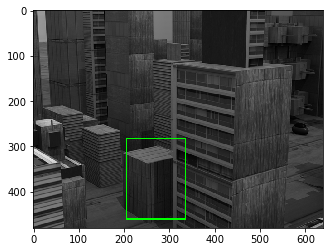

Optical flow computed
4.771894826312437
[206, 283, 336, 460]
[205, 283, 335, 460]


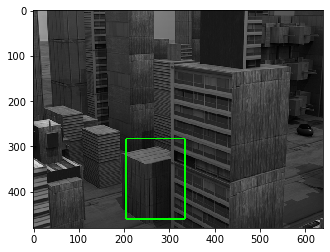

Optical flow computed
7.198964073193322
[205, 283, 335, 460]
[204, 283, 334, 460]


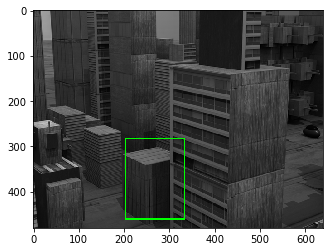

Optical flow computed
9.71836456850911
[204, 283, 334, 460]
[204, 283, 334, 460]


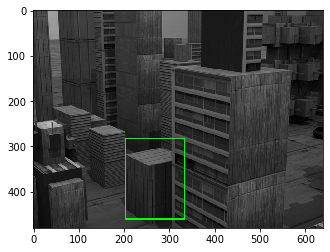

In [12]:
    dataset_complete = './eval-data-gray-complete'
    directory = '/Urban'
    bbox = [208, 284, 338, 461]
    bounding_box_tracking(dataset_complete + directory)